# Clairvoyante (Model Training Demo)


In [1]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import numpy as np
import time
import pickle
from random import randrange

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import clairvoyante
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import clairvoyante.utils_v2 as utils
import clairvoyante.clairvoyante_v2 as cv
import clairvoyante.param as param

/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Instructions for updating:
non-resource variables are not supported in the long term


## Train using the chr21+chr22 variants

In [3]:
# Load the preprocessed and compressed tensors into memory
with open("/scratch/mu2047/Project/outputs_new/tensor.bin", "rb") as fh:
    total = pickle.load(fh)
    XArrayCompressed = pickle.load(fh)
    YArrayCompressed = pickle.load(fh)
    posArrayCompressed = pickle.load(fh)

In [4]:
print("The size of training dataset: {}".format(total))

The size of training dataset: 5957618


In [5]:
total = int(0.035 * total)
print(total)

208516


In [6]:
# Pick a random candidate
i = randrange(total)
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

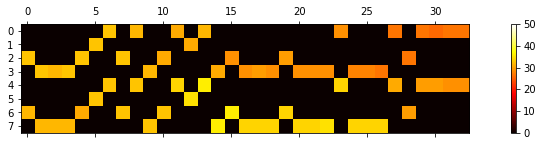

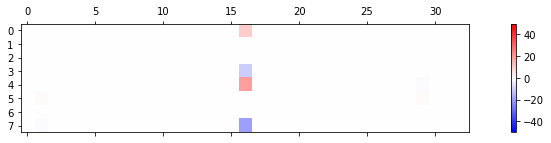

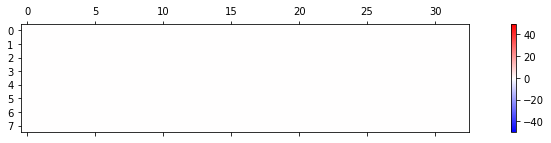

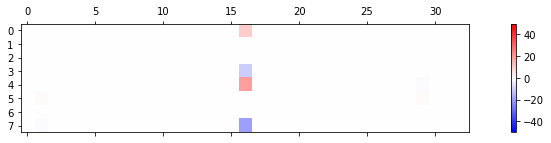

In [7]:
# Show how the four matrices are like
figure(figsize=(15, 2)); matshow(XArray[0,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.hot, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,3].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()

In [8]:
# create a Clairvoyante network
m = cv.Clairvoyante()
m.init()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


../clairvoyante/clairvoyante_v2.py:49: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(inputs=XPH,
../clairvoyante/clairvoyante_v2.py:58: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool1 = tf.compat.v1.layers.max_pooling2d(inputs=conv1,
../clairvoyante/clairvoyante_v2.py:64: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(inputs=pool1,
../clairvoyante/clairvoyante_v2.py:73: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool2 = tf.compat.v1.layers.max_pooling2d(inputs=conv2,
../clairvoyante/clairvoyante_v2.py:79: UserWarning: `tf.layers.conv2d` is 

In [9]:
# training the model. The code train on all variants and validate on the first 10% variant sites
trainingStart = time.time()
trainBatchSize = 512
validationLosses = []
numValItems = int(len(XArray) * 0.1 + 0.499)
print("Start at learning rate: %.2e" % m.setLearningRate(0.001))
c = 0; maxLearningRateSwitch = 2
epochStart = time.time()
datasetPtr = 0
epochs = 1
numValItems = int(total * 0.1 + 0.499)
valXArray, _, _ = utils.DecompressArray(XArrayCompressed, 0, numValItems, total)
valYArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, numValItems, total)
print("Number of variants for validation: %d" % len(valXArray))
i = 1
while i < (1 + int(epochs * total / trainBatchSize + 0.499)):

    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, trainBatchSize, total)
    YBatch, _, _ = utils.DecompressArray(YArrayCompressed, datasetPtr, trainBatchSize, total)
    loss, _ = m.train(XBatch, YBatch)
    if endFlag != 0:
        validationLoss = m.getLoss( valXArray, valYArray )
        print(" ".join([str(i),\
                                       "Training losses:", str(loss/trainBatchSize),\
                                       "Validation losses: ", str(validationLoss/numValItems),\
                                       "Epoch time elapsed: %.2f s" % (time.time() - epochStart)]))
        validationLosses.append( (validationLoss, i) )
        c += 1
        flag = 0
        if c >= 5:
            if validationLosses[-5][0] - validationLosses[-4][0] < 0:
                if validationLosses[-4][0] - validationLosses[-3][0] > 0:
                    if validationLosses[-3][0] - validationLosses[-2][0] < 0:
                        if validationLosses[-2][0] - validationLosses[-1][0] > 0:
                            flag = 1
            elif validationLosses[-5][0] - validationLosses[-4][0] > 0:
                if validationLosses[-4][0] - validationLosses[-3][0] < 0:
                    if validationLosses[-3][0] - validationLosses[-2][0] > 0:
                        if validationLosses[-2][0] - validationLosses[-1][0] < 0:
                            flag = 1
            else: flag = 1
        if flag == 1:
            maxLearningRateSwitch -= 1
            if maxLearningRateSwitch == 0: break
            print("New learning rate: %.2e" % m.setLearningRate())
            c = 0
        epochStart = time.time()
        datasetPtr = 0
    i += 1
    datasetPtr += trainBatchSize

print("Training time elapsed: %.2f s" % (time.time() - trainingStart))

Start at learning rate: 1.00e-03
Number of variants for validation: 20852
Training time elapsed: 24.20 s


## Testing on the training dataset

In [10]:
predictStart = time.time()
predictBatchSize = 20
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print(sys.stderr, "Prediciton time elapsed: %.2f s" % (time.time() - predictStart))

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print("\n\nVersion 2 model, evaluation on base change:")
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print("all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100))
print("\n\nVersion 2 model, evaluation on Zygosity:")
ed = np.zeros( (2,2))
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print("\t".join([str(ed[i][j]) for j in range(2)]))
print("\n\nVersion 2 model, evaluation on variant type:")
ed = np.zeros( (4,4))
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print("\t".join([str(ed[i][j]) for j in range(4)]))
print("\n\nVersion 2 model, evaluation on indel length:")
ed = np.zeros( (6,6))
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print("\t".join([str(ed[i][j]) for j in range(6)]))

<ipykernel.iostream.OutStream object at 0x14cd84df9a30> Prediciton time elapsed: 69.04 s


Version 2 model, evaluation on base change:
all/top1/top2/top1p/top2p: 208516/183975/202616/88.23/97.17


Version 2 model, evaluation on Zygosity:
194961.0	10538.0
619.0	2398.0


Version 2 model, evaluation on variant type:
29637.0	39548.0	1668.0	52905.0
118.0	32457.0	32.0	3267.0
16.0	648.0	1840.0	194.0
274.0	10632.0	45.0	35235.0


Version 2 model, evaluation on indel length:
25111.0	15928.0	907.0	6813.0	21348.0	133377.0
147.0	246.0	91.0	41.0	135.0	35.0
228.0	122.0	279.0	58.0	75.0	99.0
127.0	13.0	94.0	216.0	26.0	47.0
131.0	37.0	47.0	31.0	356.0	40.0
28.0	11.0	6.0	11.0	28.0	2227.0


## Testing on the chr22 variants

In [ ]:
! pip install intervaltree

In [ ]:
import clairvoyante.utils_v2 as utils

In [ ]:
!pip list

In [ ]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("/scratch/mu2047/Project/Clairvoyante/training/tensor_can_chr22",
                       "/scratch/mu2047/Project/Clairvoyante/training/var_chr22",
                       "/scratch/mu2047/Project/Clairvoyante/training/bed")
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)

In [ ]:
XArrayCompressed

In [ ]:
print("Testing on the training and validation dataset ...")
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
print(XBatch.shape)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print("Prediciton time elapsed: %.2f s" % (time.time() - predictStart))

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print("Version 2 model, evaluation on base change:")
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print("all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100))
print("Version 2 model, evaluation on Zygosity:")
ed = np.zeros( (2,2))
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print("\t".join([str(ed[i][j]) for j in range(2)]))
print("Version 2 model, evaluation on variant type:")
ed = np.zeros( (4,4))
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print("\t".join([str(ed[i][j]) for j in range(4)]))
print("Version 2 model, evaluation on indel length:")
ed = np.zeros( (6,6) )
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print("\t".join([str(ed[i][j]) for j in range(6)]))

## Visualizing predictions

In [ ]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],zs[arrayStart:arrayEnd,:],\
                         ts[arrayStart:arrayEnd,:],ls[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)